<a href="https://colab.research.google.com/github/laurabersani/MLPNS_LBersani/blob/main/ConvlutionalNN_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [4]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"]= "nearest" #tolgo l'interpolazione tra i pixel che automaticamente farebbe pylab con imshow
plt.rcParams["image.cmap"]="gist_gray"

In [5]:
cd /content/drive/MyDrive/MLPNS2023

/content/drive/MyDrive/MLPNS2023


In [6]:
ls

higgsboson/     spm-20210427T111354Z-001.zip  wine.data.1
kaggleTitanic/  wine.data                     wine.names


In [7]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
  inflating: spm/spm_struct_pos.npy  
  inflating: spm/spm_struct_neg.npy  
  inflating: spm/test_good_all.npy   
  inflating: spm/train_good_all.npy  
  inflating: spm/test_bad_all.npy    
  inflating: spm/train_bad_all.npy   


In [9]:
#sono file numpy array. Per leggerli:
data=np.load("spm/train_good_all.npy")
#(np.save per salvare i numpy array)

In [10]:
data.shape
#1302 immagini, 64x64

(1302, 64, 64)

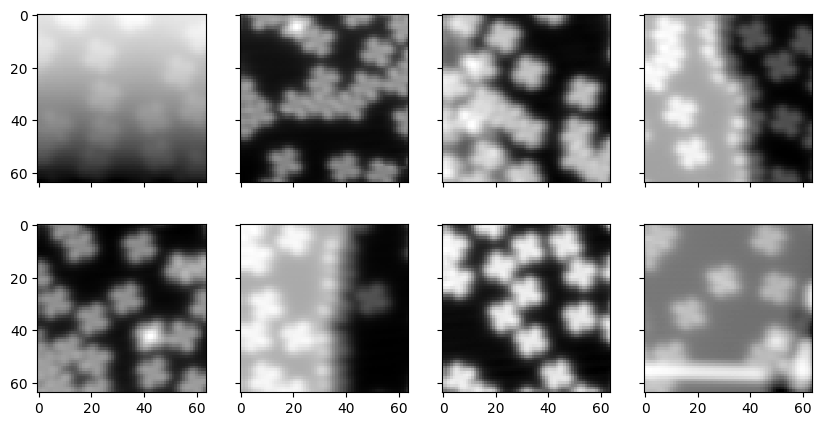

In [11]:
#ne visualizziamo alcune
fig, ax=plt.subplots(2,4, figsize=[10,5], sharex=True, sharey=True)
for ii in range(8):
  ax[ii//4, ii%4].imshow(data[ii])

In [12]:
#Vogliamo creare un object detector: deve trovare la dimensione di specifici oggetti nelle immgini
#per farlo dobbiamo trainarlo, quindi di alcune dobbiamo conoscere la posizione di alcune immagini.
#useremo convlutional map, che va a cercare oggetti nelle immagini

(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

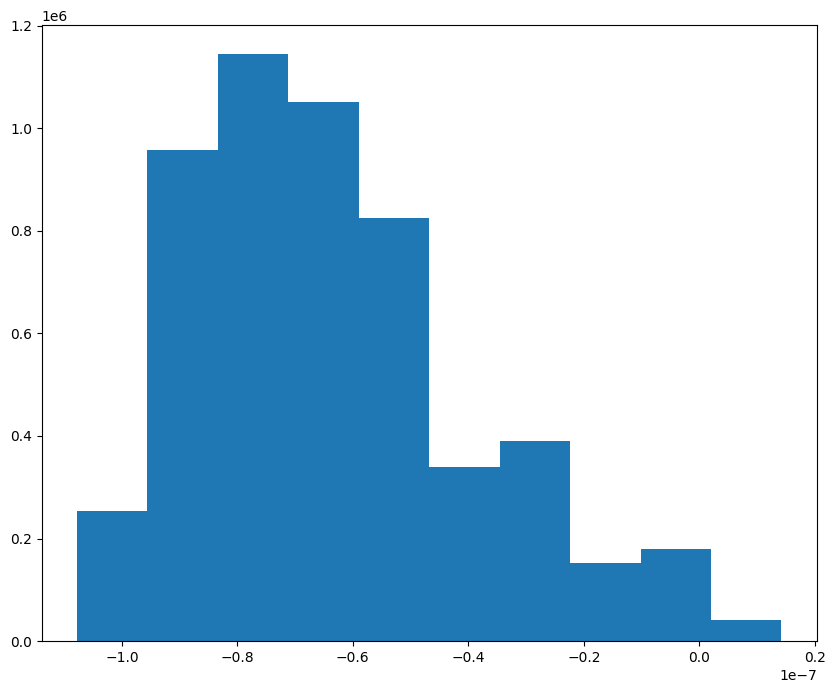

In [13]:
#valutiamo il range dei dati
plt.hist(data.flatten())

In [20]:
#per normalizzare: norm=(D-MIN(D))/RANGE(D)
norm=(data - data.min(axis=(1,2),keepdims=True))/(data.max(axis=(1,2),keepdims=True) - data.min(axis=(1,2),keepdims=True))

In [18]:
norm.shape

(1302, 64, 64)

In [21]:
norm.min(), norm.max()

(0.0, 1.0)

In [23]:
pos = np.load("spm/spm_struct_pos.npy")
neg= np.load("spm/spm_struct_neg.npy")
#pos e neg contngono le fiugure dove (non) sono state trovate le molecole. Al loro interno si trova la posizione delle molecola all'interno dell'immagine.

In [24]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [25]:
pos[0]

array([30, 25, 51])

In [26]:
pos.max(axis=0)
#il numero dell'immagine è il terzo

array([  62,   62, 1300])

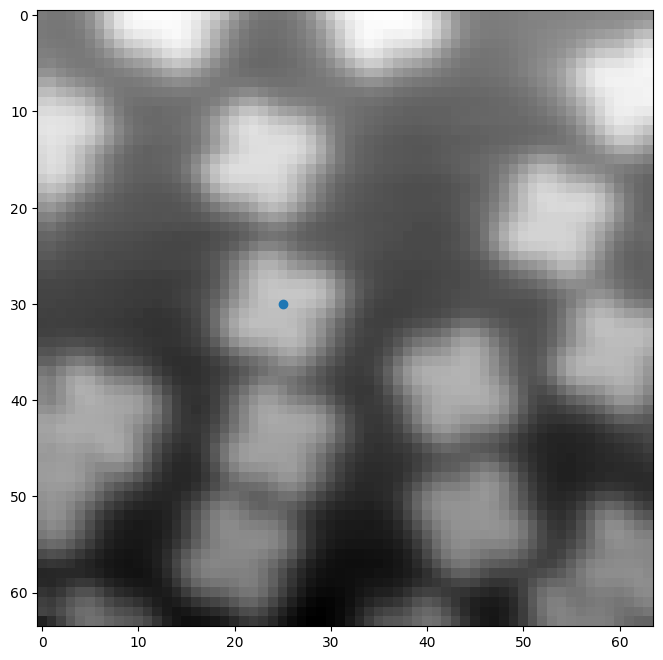

In [32]:
plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1], pos[0][0], 'o')

In [33]:
#ora: devo creare lo stamps che dovrò fare scorrere sull'immagine per trovare la molecola. 
wid=10 #a occhio vediamo che è circa 10x10
stmp_pos = []
for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid,])

stmp_pos = np.array(stmp_pos)

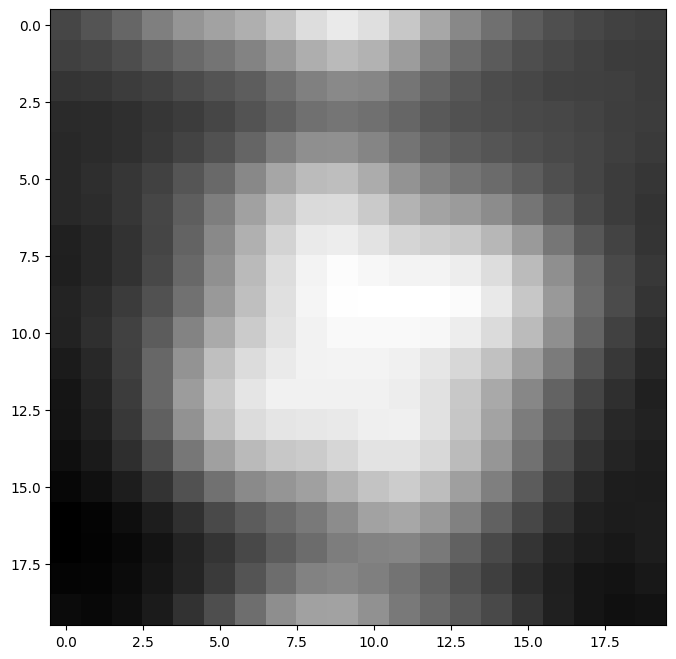

In [34]:
plt.imshow(stmp_pos[0])

In [35]:
#stessa cosa per neg
wid=10 
stmp_neg = []
for ii in range(neg.shape[0]):
  trow, tcol, tind = neg[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid,])

stmp_neg = np.array(stmp_neg)

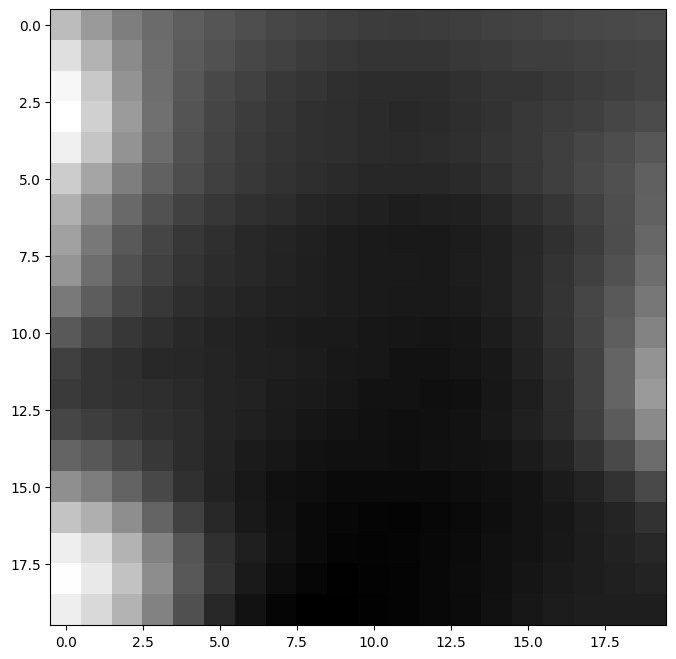

In [37]:
plt.imshow(stmp_neg[0])
#vediamo che non è una molecola
#è importante dargli anche i neg perchè potrebbero esserci immagini fraintendibili e lui deve sapere quali scartare 

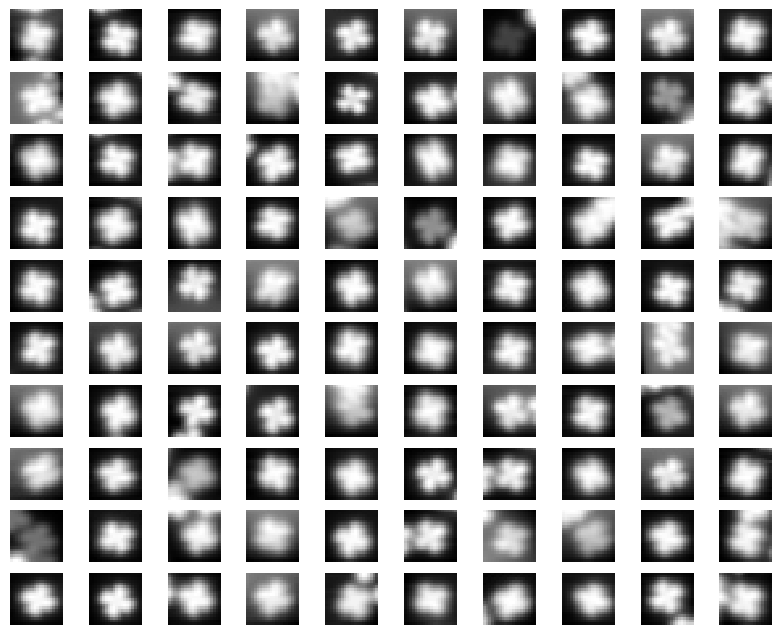

In [38]:
# plot  positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

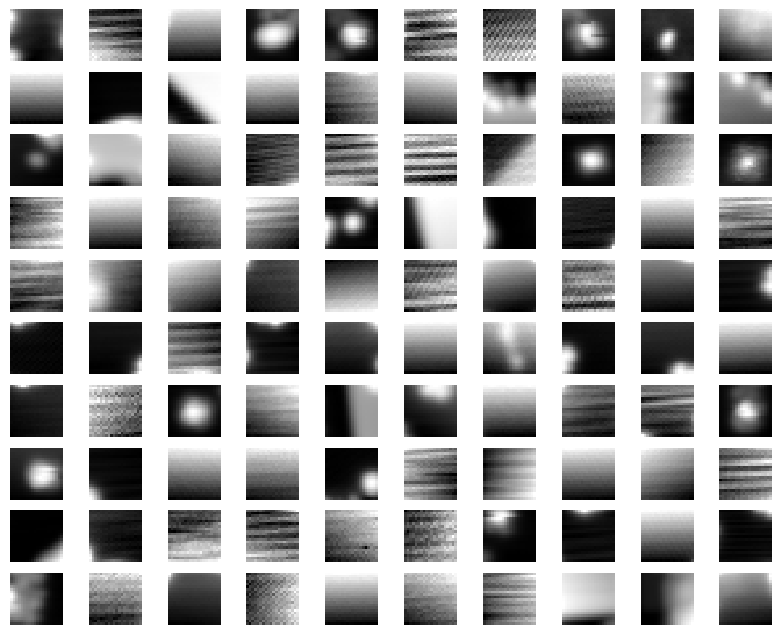

In [39]:
# plot  negative examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [ ]:
#Nel negative set le forme da riconoscere sono molto diverse, è bene che il set neg sia più grande.

In [42]:
feat =np.concatenate((stmp_neg, stmp_pos), axis=0) #feature
targ =np.concatenate((np.zeros(stmp_neg.shape[0]), np.ones(stmp_pos.shape[0])), axis=0) #target: 1 se pos, 0 se neg

In [44]:
feat.shape

(874, 20, 20)

In [45]:
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ, random_state=302, shuffle=True)
#è importante shuffolare il set, perchè avendo i dati sono ordinati lo split non viene ben
feat_tr.shape


(655, 20, 20)

In [46]:
feat_tr = np.expand_dims(feat_tr, axis=3) #va aumentata la dimensionalità, perchè poi la func si aspetta una dim in più. 
feat_te = np.expand_dims(feat_te, axis=3)
feat_tr.shape

(655, 20, 20, 1)

#create a NN:
- conv2d 16 neurons
- MaxPool2d
- conv2d 32 neuron
- maxpool2d
- flatten
- dense 64 neurons
- dense 2 neurons

In [61]:
layer1 = keras.layers.Conv2D(16, #n di neuroni
                             kernel_size=(5, 5), #dim della mappa di convoluzione 
                             padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1), #needed in the first layer only
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(2) #solo la dim con cui fare pooling

layer3 = keras.layers.Conv2D(32, 
                             kernel_size=(5, 5), #dim della mappa di convoluzione 
                             padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer4 = keras.layers.MaxPool2D(2)

layer5 = keras.layers.Flatten()

layer6 = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))

layer7 = keras.layers.Dense(2, activation="softmax")
#siccome l'output è binario, uso softmax

layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [63]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [64]:
#salvo in una variabile history per plottare la loss function
history = model.fit(feat_tr, targ_tr, epochs=50,
                    batch_size=50, #per evitare overfitting
                    validation_split=0.1) #fa una cross validation sul 10% dei dati

Epoch 1/50
12/12 [==============================] - 4s 102ms/step - loss: 0.6975 - accuracy: 0.7589 - val_loss: 0.5392 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 0s 39ms/step - loss: 0.5041 - accuracy: 0.9049 - val_loss: 0.3668 - val_accuracy: 0.8788
Epoch 3/50
12/12 [==============================] - 0s 40ms/step - loss: 0.3829 - accuracy: 0.9032 - val_loss: 0.3467 - val_accuracy: 0.8939
Epoch 4/50
12/12 [==============================] - 0s 38ms/step - loss: 0.3248 - accuracy: 0.9117 - val_loss: 0.3729 - val_accuracy: 0.8788
Epoch 5/50
12/12 [==============================] - 0s 39ms/step - loss: 0.3111 - accuracy: 0.9270 - val_loss: 0.2775 - val_accuracy: 0.9091
Epoch 6/50
12/12 [==============================] - 0s 38ms/step - loss: 0.2623 - accuracy: 0.9389 - val_loss: 0.2856 - val_accuracy: 0.9242
Epoch 7/50
12/12 [==============================] - 0s 38ms/step - loss: 0.2578 - accuracy: 0.9372 - val_loss: 0.3371 - val_accuracy: 0.9091
Epoch 8/50
1

In [65]:
history.history["val_accuracy"]

[0.9090909361839294,
 0.8787878751754761,
 0.8939393758773804,
 0.8787878751754761,
 0.9090909361839294,
 0.9242424368858337,
 0.9090909361839294,
 0.9090909361839294,
 0.9242424368858337,
 0.939393937587738,
 0.939393937587738,
 0.9696969985961914,
 0.9696969985961914,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9848484992980957,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0.9696969985961914,
 0.9545454382896423,
 0.9545454382896423,
 0.9696969985961914,
 0.9696969985961914,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423,
 0.9545454382896423

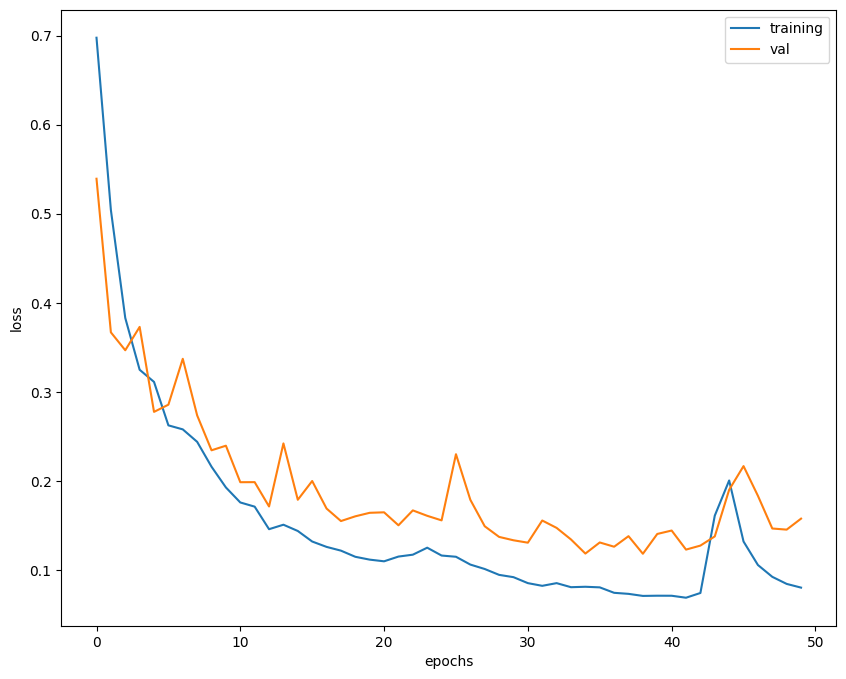

In [69]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

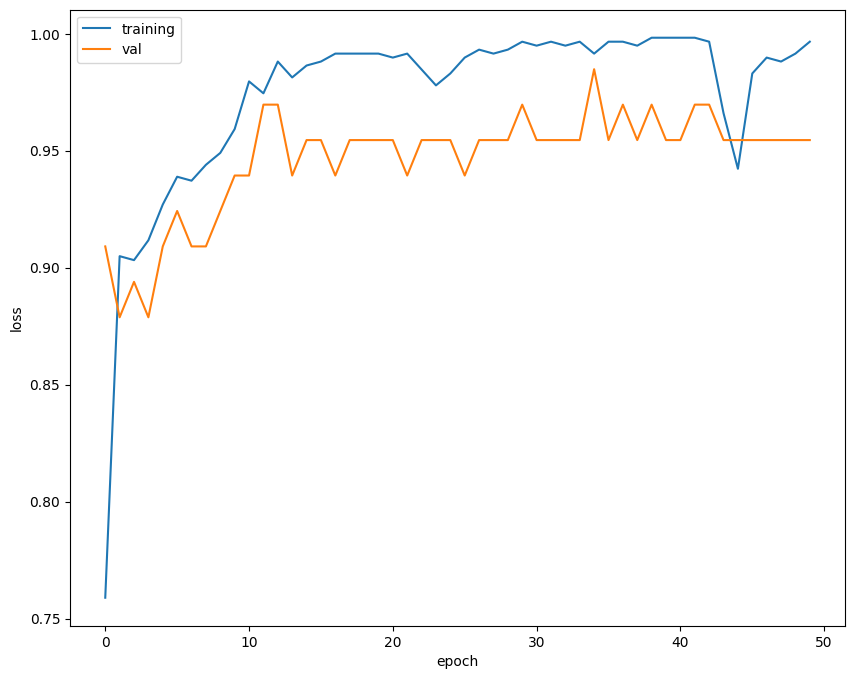

In [75]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();

In [74]:
loss_tr, acc_tr=model.evaluate(feat_tr, targ_tr)
loss_te, acc_te=model.evaluate(feat_te, targ_te)
print((4*'{:.3f}\t').format(loss_tr, acc_tr, loss_te, acc_te))

7/7 [==============================] - 0s 16ms/step - loss: 0.1132 - accuracy: 0.9863
0.085	0.994	0.113	0.986	
